In [12]:
### Topic extraction and visualization using clustering, BERT and 


In [13]:
# !pip install umap-learn
# !pip install sklearn
# !pip install sentence_transformers
# !pip install hdbscan

In [14]:
import numpy as np 
import pandas as pd 
import hdbscan # this library will be used for clustering
import random



Identifying topics specific to clusters generated from UMAP.

Topic modeling is an unsupervised machine learning technique to automatically identify the "topics" that occur in a collection of documents.

There are various popular algorithms to identify topics in a document.

  One of the most apparochaes is LDA.  (very interesting paper that describes LDA https://www.cs.columbia.edu/~blei/papers/Blei2012.pdf)

* How can we use HuggingFace, specifically BERT Embedding, to derive topics inherent to a collection of documents?

The main topic of this article will not be the use of BERTopic but a tutorial on how to use BERT to create your topic model.



#### 1. Getting the data

Dataset: 18000 posts, in 20 newsgroup topics. 
Run the following code cell

In [15]:
from sklearn.datasets import fetch_20newsgroups
download = fetch_20newsgroups(subset="all")


* Inspect the variable `download`. Extract the data contained in `download` and save it to a variable called `data`

In [16]:
### Write your code here.
# You  can use dir, or simply display download
data = download['data']

* Create a new variable called `data_subset` that contains 5k randomly selected instances. Use the `sample()` function from the `random` package.

In [17]:
data_subset = random.sample(data, 5_000)
len(data_subset)

5000

In [18]:
data_subset[0]

'From: rlglende@netcom.com (Robert Lewis Glendenning)\nSubject: Re: The Old Key Registration Idea...\nOrganization: Netcom - Online Communication Services (408 241-9760 guest)\nLines: 25\n\nThe Clipper Chip will have no effect.  Current generation PCs, portable\nand desktop, all have analog voice -> digital voice and vice versa\ncapabilities.  So, I only need a modem output to the telephone,\nand I can interpose any encryption screen on my voice traffic I want.\n\nNot even a big deal, but it will pass muster if the have a way\nof checking whether I am using their Clipper Chip encryption without\na full decoding.\n\nI have been chided for stating that Dorthy Denning was intellectually\ndishonest in the ACM debate and in this newsgroup.  I have previously\nrefrained from suggesting that she is arguing on behalf of consulting\nclients.\n\nNow, I say that it is clear that Dorthy Denning has been functioning\nas a lobbyist, not a computer scientist.  She has used legal ethics\n(truth is wha


#### 2. Embeddings
* Use  'sentence-transformers' to convert the messages to embeddings.


In [19]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')


/Users/mahdi/miniconda3/envs/s3-next/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
embeddings = model.encode(data_subset, show_progress_bar=True)
embeddings.shape

Batches: 100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:17<00:00,  2.02it/s]


(5000, 768)

In [21]:
embeddings.shape

(5000, 768)

In [22]:
embeddings[0][0:10]

array([-0.88484395, -0.2552238 ,  0.2166677 ,  0.2575337 , -0.2436337 ,
       -0.7838319 ,  0.24617298, -0.2996973 ,  0.38857612,  0.39717838],
      dtype=float32)

#### 3. Dim. Reduction

We need to identify clusters in the data but input of 768 is too large. Therefore, we will use UMAP to lower the dimensionality of the daa

a UMAP instance can be constructed as follow. See the documentation for more details (https://umap-learn.readthedocs.io/en/latest/parameters.html)

```python
umap_instnace = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='?')`
                            
```                            
* Which distance do you think if most appropriate to use here?

* Reduce the dimensionality of the input to 5
  * Set the size of the local neighborhood to 15

* How can you determin a good value for the size of the local neighborhood?


In [23]:
import umap
umap_instance = umap.UMAP(n_neighbors=20, 
                            n_components=10, 
                            metric='cosine')


Use the `fit_transform` method of `umap_instance` to change the dimensionality of the data

In [25]:
umap_embeddings = umap_instance.fit_transform(embeddings)
umap_embeddings.shape

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(5000, 10)

In [26]:
umap_embeddings.shape

(5000, 10)

In [27]:
umap_embeddings[0]

array([ 7.774659  ,  1.0834537 , -1.3445214 , -1.2374936 ,  2.3355358 ,
        7.769621  ,  9.42639   ,  6.449998  , -0.14865196,  8.723768  ],
      dtype=float32)

* Normalize the vectors are discussed in class during the practical's session

In [28]:
# Write your code here
umap_embeddings.sum(axis=1).reshape(-1,1)
umap_embeddings /= umap_embeddings.sum(axis=1).reshape(-1,1)
umap_embeddings

array([[ 0.19040251,  0.02653393, -0.03292752, ...,  0.15796137,
        -0.00364051,  0.21364632],
       [ 0.16701718,  0.03402906, -0.00970978, ...,  0.18673132,
         0.02088007,  0.19752723],
       [ 0.1646823 ,  0.02884761, -0.01374782, ...,  0.1806234 ,
         0.02002948,  0.20543769],
       ...,
       [ 0.18687077,  0.01009935, -0.04427319, ...,  0.20815961,
        -0.01453919,  0.21013756],
       [ 0.1648693 ,  0.04514684, -0.02870037, ...,  0.16475186,
         0.06311479,  0.16770697],
       [ 0.20042342,  0.004537  , -0.05257099, ...,  0.19637567,
        -0.02243483,  0.21656196]], dtype=float32)

In [29]:
umap_embeddings.shape

(5000, 10)

In [30]:
umap_embeddings[0].sum()

1.0

In [31]:
umap_embeddings[0].sum()

1.0

#### 4. Cluster the Data Using HDBSCAN

* We don't know the number of inherent clusters, so let's use HDBSCAN; Hierarchical Density-Based Spatial Clustering of Applications with Noise. 

* You can read about HDBSCAN here, but essentially, to run it on HDBSCAN on the embeddings using the following:

https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html


In [32]:

import hdbscan
hdbscan_instance = hdbscan.HDBSCAN(min_cluster_size=20,
                          metric='euclidean',                      
                          cluster_selection_method='eom')

clusters = hdbscan_instance.fit(umap_embeddings)


Knowing that the cluster labels for each input are stored in `clusters.labels_`. How many clusters are there and how many instances are in each cluster?

In [33]:
%time
import hdbscan
hdbscan_instance = hdbscan.HDBSCAN(min_cluster_size=20,
                          metric='euclidean',                      
                          cluster_selection_method='eom')

clusters = hdbscan_instance.fit(umap_embeddings)

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 11.9 µs


In [34]:
class test:
    def __init__(self, x):
        self.x = x 
        

In [35]:
from collections import Counter

In [36]:
Counter([1,1,1,3,2,1,2,3,5,6,7])

Counter({1: 4, 3: 2, 2: 2, 5: 1, 6: 1, 7: 1})

In [33]:
### Write your code here
from collections import Counter
print(set(clusters.labels_))

Counter(clusters.labels_)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, -1}


Counter({-1: 2952,
         17: 258,
         3: 39,
         2: 127,
         24: 130,
         4: 228,
         11: 44,
         16: 54,
         8: 47,
         19: 36,
         18: 31,
         23: 179,
         1: 55,
         15: 153,
         22: 158,
         0: 155,
         5: 29,
         21: 20,
         9: 45,
         14: 33,
         7: 50,
         6: 25,
         13: 24,
         10: 75,
         20: 27,
         12: 26})

* -1 refers to all documents that were not assigned to a cluster.

  * This is rather an advantage, not a drawback of HDBSCAN, can you hypothesize why?

#### 5. Topic Visualization
* To visualize the resulting clusters we can further reduce the dimensionality to 2.
* Plot the points in scatter plots
* Show the outliers in a different color (ex. grey)

,x,y,labels
3119,12.645499,8.890868,23
304,9.237557,9.934369,-1
4582,11.594903,9.302244,-1
4307,10.126619,4.497151,1
407,12.067133,11.995161,-1
1511,9.942798,7.808773,-1
111,9.803210,9.681222,19
3507,12.304939,9.108838,23
1371,6.746838,9.269311,15
1903,6.373446,8.871652,-1


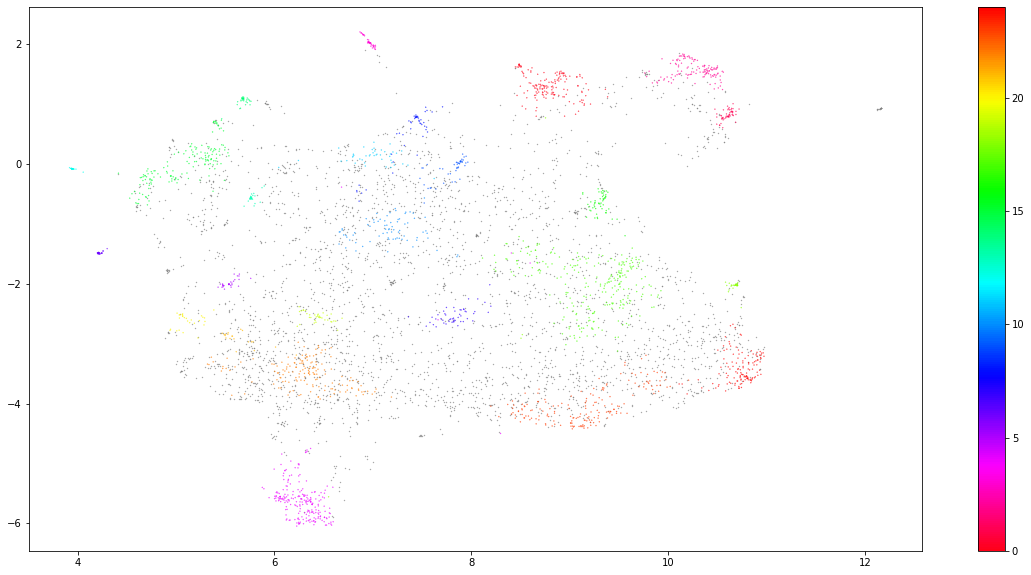

Analyze the data without outliers. Is the viz supporting your hypothesis about the benefit of having HDBSCAN assing -1 to outliers?

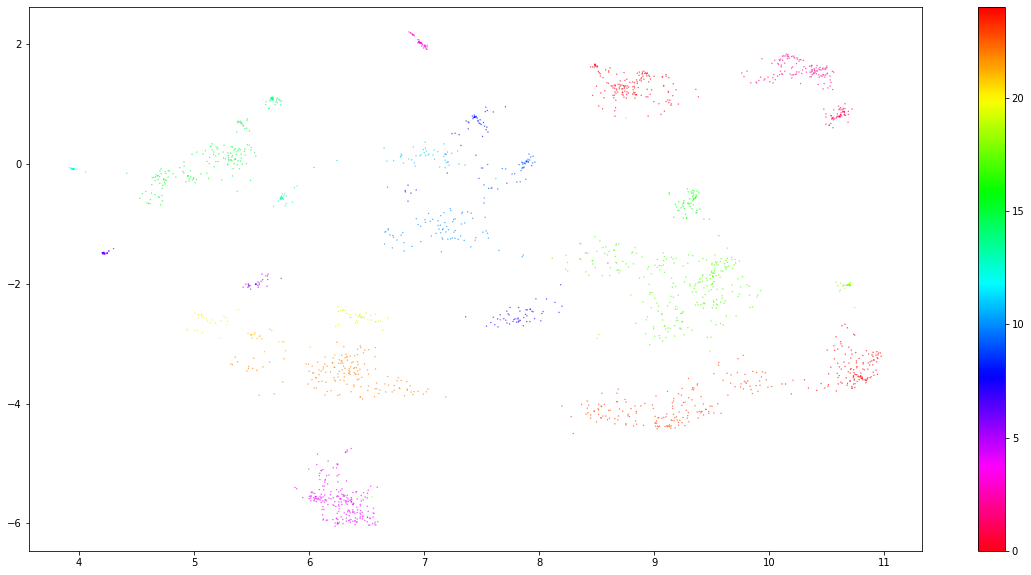


## **4. Topic Creation**

* How can we derive topics from clustered documents?

  * We can use an apporach that is similar to that used in 2nd assignment. Namely, instead of treating each document as a category, concatenate all the docs in each cluster and identify words with high `tf-idf` values across clusters.

* You can use the `TfidfVectorizer` class in the `sklearn.feature_extraction.text` module. 
* You can assume that you're working on a small subset that fits in RAM.
* Start by combining all documents in each category. 

In [76]:
docs_df = pd.DataFrame(data_subset, columns=["Doc"])
docs_df['Topic'] = clusters.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_df.head()

,Doc,Topic,Doc_ID
0,From: timbol@netcom.com (Mike Timbol)\nSubject...,-1,0
1,From: kmr4@po.CWRU.edu (Keith M. Ryan)\nSubjec...,-1,1
2,From: stusoft@hardy.u.washington.edu (Stuart D...,17,2
3,From: pat@rwing.UUCP (Pat Myrto)\nSubject: Re:...,-1,3
4,From: heinboke@tnt.uni-hannover.de (Andreas He...,-1,4


In [78]:
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
docs_per_topic.shape


(26, 2)

In [79]:
docs_per_topic.head()

,Topic,Doc
0,-1,From: timbol@netcom.com (Mike Timbol)\nSubject...
1,0,From: tedward@cs.cornell.edu (Edward [Ted] Fis...
2,1,From: steveh@thor.isc-br.com (Steve Hendricks)...
3,2,From: etxonss@ufsa.ericsson.se (Staffan Axelss...
4,3,From: sera@zuma.UUCP (Serdar Argic)\nSubject: ...


In [103]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(analyzer='word', stop_words='english')


In [104]:
tfidf_vals = tfidf_vectorizer.fit_transform(docs_per_topic.Doc.tolist())
tfidf_vals.shape

(26, 71799)

In [123]:
words = tfidf_vectorizer.get_feature_names()
len(words)

71799

In [124]:
np.random.seed(301)
np.random.choice(words, 100)

array(['morgan', 'viii', 'columnists', 'buckner', 'toenails', 'rub',
       'zzr11', 'c5uhfw', 'allowance', 'birinci', 'migrans',
       'ottawa_bearcats', 'cog', 'morph', 'optical', 'mayans', 'educated',
       'neccd', 'iacd', 'rectifier', 'runnining', 'demuxes', 'preferred',
       'u9exzfptpgajwy91dsafx0h53rv5', 'moires', 'neccities', 'especkma',
       'bennies', 'mrm', 'berehowsky', '6k', 's0d', 'adm', 'j1ri',
       'stampe', 'kfp', 'awkward', 'nepal', '7dv', 'nineveh', 'earn',
       'flaw', 'swears', 'j0', 'sucky', 'cse', 'rat', 'adultery', '_oy',
       'dabro', 'journeymen', '074836', 'supported', 'rubrics', 'prior',
       'ccw', '174430', '3818', 'dividend', 'psis', 'kivoosh', 'nlsun1',
       'sparcstation', 'lkwj', 'whacha', '24844', 'rekindled', 'aiding',
       'underline', 'px8', 'lafontaine', 'rpg', 'sit', 'ir2tbh', '760',
       'llibce', 'bht', 'spock', 'beehive', 'stuffed', 'pawning',
       'edouard', 'verifying', 'bullshitting', 'gyx_sc_', 'licnese',
       'rep

* Extract the most important 10 words for each topics based on the TF-IDF scores.
  * Remember that the higher the score, the more representative it should be of its topic as the score is a proxy of information density.

array([[1.75343412e-02, 9.45892822e-03, 7.79740227e-05, ...,
        8.78625197e-05, 8.78625197e-05, 8.78625197e-05]])

In [144]:

sorted(zip(tfidf_vals[1].toarray()[0], words), key=lambda x: x[0], reverse=True)


[(0.3074847968372109, 'edu'),
 (0.18763672669226664, 'game'),
 (0.1697096577890586, 'players'),
 (0.16601407516531913, 'baseball'),
 (0.1495109562602952, 'com'),
 (0.1495109562602952, 'subject'),
 (0.14763031530104623, 'organization'),
 (0.14668999482142173, 'lines'),
 (0.12504731486437815, 'clutch'),
 (0.11068556001613725, 'hit'),
 (0.11036279942147648, 'year'),
 (0.1060648424430682, 'braves'),
 (0.1053158937179438, 'writes'),
 (0.10124931612640183, 'pitching'),
 (0.09970583861052316, 'games'),
 (0.0988946808676483, 'hits'),
 (0.0970468406883393, 'team'),
 (0.09309172748282532, 'article'),
 (0.08462884316620484, 'don'),
 (0.08360958582380001, 'win'),
 (0.08343988370447268, 'league'),
 (0.08336050643196895, 'blues'),
 (0.08209497406424471, 'jewish'),
 (0.07992724076808234, 'think'),
 (0.0779167065379718, 'sabo'),
 (0.07522563836995985, 'posting'),
 (0.07299369302135947, 'sox'),
 (0.07166357150131353, '02'),
 (0.07122322760195762, '03'),
 (0.07113346249570078, 'hitter'),
 (0.07086014508

In [152]:
sorted(zip(tfidf_vals[5].toarray()[0], words), key=lambda x: x[0], reverse=True)


[(0.39101054005586783, 'nasa'),
 (0.303002015043768, 'space'),
 (0.19240028364659337, 'gov'),
 (0.18530190712925906, 'edu'),
 (0.13479942906678707, 'orbit'),
 (0.13033997674772863, 'spacecraft'),
 (0.12721369972587965, 'shuttle'),
 (0.1254431449948074, 'subject'),
 (0.12336110109447865, 'lines'),
 (0.11971752426890332, 'organization'),
 (0.11101350836306553, 'solar'),
 (0.10886147556616278, 'launch'),
 (0.10627081054747838, 'mission'),
 (0.10307275895839238, 'earth'),
 (0.0983765742905336, 'article'),
 (0.09788100971478271, 'mars'),
 (0.09648837642771116, 'moon'),
 (0.09228780915965228, 'alaska'),
 (0.09213044258954735, 'com'),
 (0.09160993161446515, 'writes'),
 (0.08792304921025214, 'planet'),
 (0.08653790507991269, 'gsfc'),
 (0.0757224403130236, 'jsc'),
 (0.07550820749426096, 'venus'),
 (0.07339204748658856, 'like'),
 (0.07299038697872803, 'atmosphere'),
 (0.07271160721669573, 'jupiter'),
 (0.06908018767629617, 'satellite'),
 (0.06823180977454654, 'comet'),
 (0.06772574517903426, 'su

In [156]:
sorted(zip(tfidf_vals[11].toarray()[0], words), key=lambda x: x[0], reverse=True)

[(0.2724643110522522, 'edu'),
 (0.22846386330468355, 'com'),
 (0.17600179099027471, 'writes'),
 (0.15179533353361316, 'clipper'),
 (0.13791070445732279, 'encryption'),
 (0.1353859930694421, 'lines'),
 (0.13369366815607406, 'subject'),
 (0.12729527653843542, 'forged'),
 (0.12617141784252986, 'clinton'),
 (0.12128647702847302, 'government'),
 (0.12015506884912987, 'organization'),
 (0.11507809410902578, 'article'),
 (0.10830879445555368, 'don'),
 (0.10602298720038722, 'key'),
 (0.1034017166179021, 'armenian'),
 (0.10170510152558977, 'escrow'),
 (0.09477019514860947, 'people'),
 (0.08637893765108118, 'tapped'),
 (0.08433074085200731, 'keys'),
 (0.08292392075503328, 'like'),
 (0.08292392075503328, 'posting'),
 (0.08123159584166526, 'just'),
 (0.08061152790382158, 'chip'),
 (0.076617058031846, 'administration'),
 (0.07446229618819315, 'know'),
 (0.07446229618819315, 'think'),
 (0.07126635947930816, 'enforcement'),
 (0.0710776463614571, 'host'),
 (0.06938532144808908, 'good'),
 (0.0693853214

In [164]:
sorted(zip(tfidf_vals[19].toarray()[0], words), key=lambda x: x[0], reverse=True)

[(0.34986829101056793, 'bike'),
 (0.20833162999390045, '805'),
 (0.16666530399512036, 'bikes'),
 (0.15603195884564258, 'edu'),
 (0.14770338059743016, 'ride'),
 (0.1333322431960963, '714'),
 (0.11347778825137642, 'subject'),
 (0.113379366743455, 'abate'),
 (0.10917206391983968, 'annual'),
 (0.1063854264856654, 'lines'),
 (0.1063854264856654, 'organization'),
 (0.1041888229004071, 'motorcycle'),
 (0.10217660346360821, 'mc'),
 (0.1020414300691095, 'poker'),
 (0.09574688383709885, 'com'),
 (0.095264566128738, 'jul'),
 (0.09285987607809065, '909'),
 (0.0916583677357706, 'run'),
 (0.08943052502568531, 'scma'),
 (0.08930470534320609, 'honda'),
 (0.0857381095158642, 'mx'),
 (0.07859738727969862, '818'),
 (0.07801597942282129, 'new'),
 (0.07706263335518095, 'dod'),
 (0.07665473573630169, 'fairgnds'),
 (0.07637811894763885, 'dog'),
 (0.07543558416818744, 'buy'),
 (0.07499938679780416, '310'),
 (0.07499938679780416, 'helmet'),
 (0.07499938679780416, 'tour'),
 (0.07442058778600508, 'bc'),
 (0.0722

### The following are part of the supplementary questions that are meant to substiture for assignment 3.

1. Knowing that HDBSCAN has a complexity of $n^2$, what are the big-data-related bottlenecks of the above analysis? 

  * Describe in detail how you'd handle each bottleneck.

2. What improvements would you make to the analysis above? From an analytical perspective rather than a computational one.

3. How would you handle instances assigned a -1 by HDBSCAN? I.e., 1. would you throw them away or would you assingn them back into the cluster by using "some approach or heuristitic" to do so?  If you chose 1, then describe why? If you chose 2., describe how?

4. K-means would work very well with the cosine distance. How would you go about findind the best value of k?

5. Discribe the approch you'd use to reduce the number of topics obtained?